In [1]:
import os
import random
import tensorflow as tf
import pandas as pd
import numpy as np
import shutil
import seaborn
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report


In [2]:
# src_path: input the path of the folder, where the whole data is stored
# label_path: dataframe which includes label data

src_path="C:/MA_Yijie_Ma/0_Datensatz/0_Training_Datensatz/1_40_Spulen/TrainingsDatensatz"
label_path = os.path.join(src_path, "40_Spulen_v1.csv")
saveModel_path = "D:/MA_Yijie_Ma/0_Datensatz/0_Training_Datensatz/1_40_Spulen/Modelle/InceptionV3_binaryClassification_v1.hdf5"
#save_logs_path = "D:/MA_Yijie_Ma/0_Datensatz/0_Training_Datensatz/1_40_Spulen/Logs/MultiOuput_Inception_4Outputs_v1_logs"

# path_Data: input the path of the folder, where the whole data is stored
#path_Data="/content/drive/My Drive/MA/CNN_V1/CNN_V1_1_Binary/"


In [3]:
# Using pretrained ResNet50 in the head of the Networks
pre_trained_model = InceptionV3(input_shape=(299, 299, 3),
                                include_top=False,
                                weights="imagenet")

for layer in pre_trained_model.layers:
    layer.trainable = False

last_layer = pre_trained_model.get_layer("mixed10")
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation="relu")(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add 4 final sigmoid layer for classification

inOrdnung = layers.Dense(1, activation='sigmoid', name="0_inOrdnung")(x)

model = Model(pre_trained_model.input, inOrdnung)
model.compile(optimizer=RMSprop(lr=0.001, decay=1e-6),
              loss="binary_crossentropy",
              metrics="accuracy")

model.summary()

last layer output shape:  (None, 8, 8, 2048)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
__________________________________________

conv2d_45 (Conv2D)              (None, 17, 17, 160)  179200      activation_44[0][0]              
__________________________________________________________________________________________________
batch_normalization_45 (BatchNo (None, 17, 17, 160)  480         conv2d_45[0][0]                  
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 17, 17, 160)  0           batch_normalization_45[0][0]     
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 17, 17, 160)  122880      mixed4[0][0]                     
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 17, 17, 160)  179200      activation_45[0][0]              
__________________________________________________________________________________________________
batch_norm

In [9]:
from tensorflow.keras.utils import plot_model
plot_model(model, expand_nested=False, show_shapes = True)

In [6]:
df = pd.read_csv(label_path)
df["Quality_Binary"] = df["Quality_Binary"].astype("str")

###.....................................................

df = df.sample(frac=1, random_state=1234).reset_index(drop=True)

###.....................................................

columns = "Quality_Binary"

datagen = ImageDataGenerator(rescale=1. / 255., validation_split=0.15)
# train_datagen=ImageDataGenerator(rescale=1./255.)
# valid_datagen=ImageDataGenerator(rescale=1./255.)

train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=src_path,
    x_col="Image",
    y_col=columns,
    subset="training",
    batch_size=64,
    shuffle=True,
    class_mode="binary",
    target_size=(299, 299))

valid_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=src_path,
    x_col="Image",
    y_col=columns,
    subset="validation",
    batch_size=64,
    shuffle=True,
    class_mode="binary",
    target_size=(299, 299))


Found 32336 validated image filenames belonging to 2 classes.
Found 5706 validated image filenames belonging to 2 classes.


In [28]:
# Using EarlyStopping Callbacks 
earlystopping = EarlyStopping(
    patience=5,
    min_delta=0,
    mode='min',
    monitor='val_loss',
    restore_best_weights=True,
    verbose=1)

# Using Tesorboard Callbacks
# tensorboard_callback = TensorBoard(log_dir=save_logs_path)

# Using ReduceLROnPlateau Callbacks
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2,
                              patience=3, min_lr=0.0001)

# Using Checkpoint Callbacks
checkpoint_filepath = saveModel_path
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    verbose=0,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_freq='epoch')

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

history = model.fit_generator(train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              epochs=2000,
                              verbose=1,
                              callbacks=[earlystopping, reduce_lr, checkpoint],
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/2000
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
505/505 [==============================] - ETA: 0s - loss: 8.7546 - accuracy: 0.8672WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000241F434E558> and will run it as-is.
Please report this to the TensorFlow team. When fili

# Evaluate and Plot

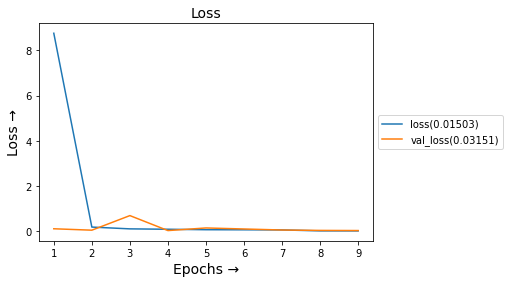

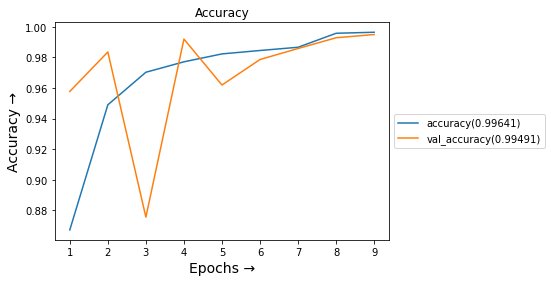

In [33]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l],  label= str(l) + '(' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l],  label= str(l) + '(' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.legend(bbox_to_anchor=(1.,.5),loc = "center left")
    plt.title("Loss", fontsize = 14)
    plt.xlabel("Epochs →", fontsize = 14)
    plt.ylabel("Loss →", fontsize = 14)
    plt.savefig("binaryClassificationLoss.jpg", dpi = 300, bbox_inches = 'tight')
   
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l],  label= str(l) + '(' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l],  label= str(l) + '(' + str(format(history.history[l][-1],'.5f'))+')')

    plt.legend(bbox_to_anchor=(1.,.5),loc = "center left") 
    plt.title('Accuracy')
    plt.xlabel("Epochs →", fontsize = 14)
    plt.ylabel("Accuracy →", fontsize = 14)
    
    plt.savefig("binaryClassificationAccurracy.jpg", dpi = 300, bbox_inches = 'tight')
    plt.show()
    
plot_history(history)

In [50]:
valid_generator_cm=datagen.flow_from_dataframe(
dataframe=df,
directory=src_path,
x_col="Image",
y_col=columns,
subset="validation",
batch_size=1,
shuffle=False,
class_mode="binary",
target_size=(299,299))

Y_pred = model.predict_generator(valid_generator_cm, steps=valid_generator_cm.n, verbose = 1)
Y_pred = np.squeeze(Y_pred, axis = 1)
Y_pred = (Y_pred> 0.5).astype(int).astype(float)
Y_pred = Y_pred.T

Y_true = np.array(valid_generator_cm.labels)


print("the shape of Y_true is: ", Y_true.shape)
print("Y_true is: ", Y_true)
print("the shape of Y_pred is: ", Y_pred.shape)
print("Y_pred is: ", Y_pred)

Found 5706 validated image filenames belonging to 2 classes.
5706/5706 [==============================] - 100s 18ms/step
the shape of Y_true is:  (5706,)
Y_true is:  [1 0 1 ... 0 1 0]
the shape of Y_pred is:  (5706, 1)
Y_pred is:  [[1.0000000e+00]
 [6.1644658e-07]
 [1.0000000e+00]
 ...
 [1.2067339e-08]
 [8.8392097e-01]
 [8.4774611e-06]]


In [52]:
#draw the classification report and confusion matrix

cm = confusion_matrix(Y_true, Y_pred)

print("the confusion matrix is: \n", cm)
print("the shape of the confusion matrix is: \n", cm.shape)

print("Classification Report: \n")
print(classification_report(Y_true, Y_pred))

the confusion matrix is: 
 [[2827   25]
 [  22 2832]]
the shape of the confusion matrix is: 
 (2, 2)
Classification Report: 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2852
           1       0.99      0.99      0.99      2854

    accuracy                           0.99      5706
   macro avg       0.99      0.99      0.99      5706
weighted avg       0.99      0.99      0.99      5706



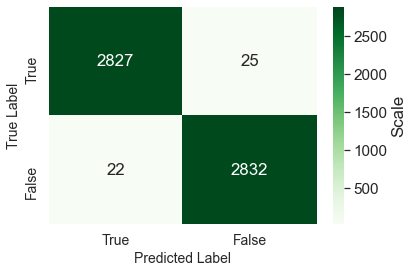

In [67]:
def plot_confusion_matrix(data, labels, title):
    """Plot confusion matrix using heatmap.
 
    Args:
        data (list of list): List of lists with confusion matrix data.
        labels (list): Labels which will be plotted across x and y axis.
        output_filename (str): Path to output file.
 
    """
    seaborn.set(color_codes=True)
    #plt.figure()
 
    plt.title(title,fontsize = 14)
 
    seaborn.set(font_scale=1.4)
    ax = seaborn.heatmap(data, annot=True, cmap='Greens', vmax=2880, fmt =".0f", cbar_kws={'label': 'Scale'})
 
    ax.set_xticklabels(labels, fontsize = 14)
    ax.set_yticklabels(labels, fontsize = 14)
 
    ax.set_xlabel("Predicted Label", fontsize = 14)
    ax.set_ylabel("True Label", fontsize = 14)
    
 
# define data
plt.figure()
labels = ["True", "False"]
title= ""
plot_confusion_matrix(cm, labels, title)


plt.imshow
plt.savefig("binaryClassificationConfusionMatrix", bbox_inches='tight', dpi=300)

In [4]:
model.load_weights("D:/MA_Yijie_Ma/0_Datensatz/0_Training_Datensatz/1_40_Spulen/Modelle/binaryClassification_v1.hdf5")

In [8]:
valid_generator_cm=datagen.flow_from_dataframe(
dataframe=df,
directory=src_path,
x_col="Image",
y_col=columns,
subset="validation",
batch_size=1,
shuffle=False,
class_mode="binary",
target_size=(299,299))

Y_pred = model.predict_generator(valid_generator_cm, steps=valid_generator_cm.n, verbose = 1)
Y_pred = np.squeeze(Y_pred, axis = 1)
Y_pred = (Y_pred> 0.5).astype(int).astype(float)
Y_pred = Y_pred.T

Y_true = np.array(valid_generator_cm.labels)


print("the shape of Y_true is: ", Y_true.shape)
print("Y_true is: ", Y_true)
print("the shape of Y_pred is: ", Y_pred.shape)
print("Y_pred is: ", Y_pred)

Found 5706 validated image filenames belonging to 2 classes.
5706/5706 [==============================] - 110s 19ms/step
the shape of Y_true is:  (5706,)
Y_true is:  [1 0 1 ... 0 1 0]
the shape of Y_pred is:  (5706,)
Y_pred is:  [1. 0. 1. ... 0. 1. 0.]


In [12]:
#draw the classification report and confusion matrix

cm = confusion_matrix(Y_true, Y_pred)

print("the confusion matrix is: \n", cm)
print("the shape of the confusion matrix is: \n", cm.shape)

print("Classification Report: \n")
print(classification_report(Y_true, Y_pred, digits=4))

the confusion matrix is: 
 [[2827   25]
 [  22 2832]]
the shape of the confusion matrix is: 
 (2, 2)
Classification Report: 

              precision    recall  f1-score   support

           0     0.9923    0.9912    0.9918      2852
           1     0.9912    0.9923    0.9918      2854

    accuracy                         0.9918      5706
   macro avg     0.9918    0.9918    0.9918      5706
weighted avg     0.9918    0.9918    0.9918      5706



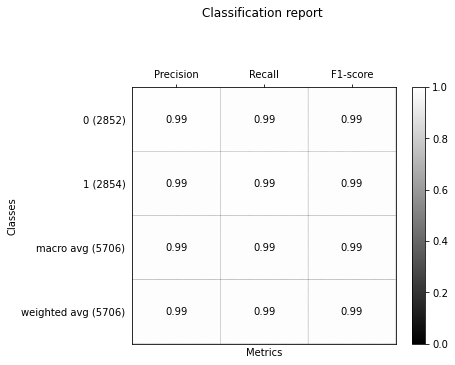

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.axes
    #ax = pc.axes# FOR LATEST MATPLOTLIB
    #Use zip BELOW IN PYTHON 3
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap, vmin=0.0, vmax=1.0)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title, y=1.25)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1line.set_visible(False)
        t.tick2line.set_visible(False)
    for t in ax.yaxis.get_major_ticks():
        t.tick1line.set_visible(False)
        t.tick2line.set_visible(False)

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, number_of_classes=2, title='Classification report ', cmap='RdYlGn'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    #drop initial lines
    lines = lines[2:]

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[: number_of_classes]:
        t = list(filter(None, line.strip().split('  ')))
        if len(t) < 4: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)


    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 15
    figure_height = len(class_names) + 8
    correct_orientation = True
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)
    plt.savefig("InceptionV3_binaryClassification_CR_v1", bbox_inches='tight', dpi=300)
    plt.show()
    
    
cr = classification_report(Y_true, Y_pred, digits=4)
plot_classification_report(cr, number_of_classes= 20, title='Classification report ', cmap=plt.cm.gray)